# Training the Models

### Prepare the functions

In [1]:
from preprocessing import preprocessing as pre

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
def prepare_data(dta):
#     dta = dta.drop(["q"], axis=1)
    X = dta.loc[:, dta.columns != 'actual']
    y = dta.loc[:, dta.columns == 'actual']
    return X,y

def ML_logistic(X_other, X_test, y_other, y_test, kf, random_state):    
    param_grid={"C":np.logspace(-5,4,num=100), "penalty":["l1","l2"]}
    logreg = LogisticRegression(solver="saga", max_iter=10000,n_jobs=-1,random_state=random_state)
    grid = GridSearchCV(logreg,param_grid=param_grid,
                        scoring=make_scorer(accuracy_score), cv=kf,
                        return_train_score=True,iid=True)
    grid.fit(X_other,y_other)
    return grid, grid.score(X_test, y_test)

@ignore_warnings(category=ConvergenceWarning)
def ML_svm(X_other, X_test, y_other, y_test, kf): 
    param_grid = {'C': np.logspace(-4,4,num=30), 'gamma': np.logspace(-4,4,num=30)}
    svc = SVC(probability=True, max_iter=10000)
    grid = GridSearchCV(svc, param_grid=param_grid,
                        scoring=make_scorer(accuracy_score),cv=kf,
                        return_train_score=True,iid=True)
    grid.fit(X_other,y_other)
    return grid, grid.score(X_test, y_test)

def ML_randomforest(X_other, X_test, y_other, y_test, kf, random_state):
    import random
    param_grid = {'max_features': ['auto', 'sqrt', 'log2'], 
                  'max_depth': random.sample(range(2, 100), 10), 
                  'min_samples_split': random.sample(range(2, 100), 10)}
    reg = RandomForestClassifier(random_state=random_state, n_jobs=-1, n_estimators=100)
    grid = GridSearchCV(reg,param_grid=param_grid,
                        scoring=make_scorer(accuracy_score),cv=kf,
                        return_train_score=True,iid=True)
    grid.fit(X_other,y_other)
    return grid, grid.score(X_test, y_test)

def ML_XGB(X_other, X_test, y_other, y_test, kf, random_state):
    import random
    param_grid = {'gamma': np.logspace(-4,4,num=10), 
                  'max_depth':random.sample(range(10, 25), 4),
                  'n_estimators': random.sample(range(200, 1000), 10)}
    xgb = XGBClassifier(learning_rate = 0.01, n_jobs=-1, random_state=random_state)
    grid = GridSearchCV(xgb,param_grid=param_grid,
                        scoring=make_scorer(accuracy_score),cv=kf,
                        return_train_score=True,iid=True)
    grid.fit(X_other,y_other)
    return grid, grid.score(X_test, y_test)

def ML_nn(X_other, X_test, y_other, y_test, kf):
    import random    
    param_grid = {'n_neighbors': random.sample(range(1, 100), 20),
                  'weights':["distance", "uniform"], 'metric': ["euclidean", "manhattan"]}
    knc = KNeighborsClassifier(n_jobs=-1)
    grid = GridSearchCV(knc,param_grid=param_grid,
                        scoring=make_scorer(accuracy_score),cv=kf,
                        return_train_score=True,iid=True)
    grid.fit(X_other,y_other)
    return grid, grid.score(X_test, y_test)

def results(grid, test_score, ML_type,x, dta_name, time):
    from datetime import datetime
    import pytz
    central = pytz.timezone("US/eastern")
    print('                                                                                                        ')
    print('###########################################', 
          "Data Set:",dta_name,
          '###########################################')
    print('###########################################',
          "ML Type:", ML_type,
          '###########################################')
    results = pd.DataFrame(grid.cv_results_)
    results["Run-Time (minutes)"]=time/60
    dateTimeObj = datetime.now().astimezone(central)
    print("Completion Time:",dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)
    print('Run time (minutes):',time/60)
    print('CV MSE:',-np.around(results[results['rank_test_score'] == 1]['mean_test_score'].values[0],2),
          '+/-',np.around(results[results['rank_test_score'] == 1]['std_test_score'].values[0],2))
    print('test MSE:',-np.around(test_score,2))
    print('Random State:',x)
    print(grid.best_estimator_)
    print('Best Accuracy:', grid.best_score_)
    print('Best Index:', grid.best_index_)
    print('########################################################################################################')
    print('                                                                                                        ')
    return results

def ML_pipeline(X, y, random_state, n_folds,x, dta_name):
    from timeit import default_timer as timer
    from datetime import datetime
    import pytz
    central = pytz.timezone("US/eastern")
    dateTimeObj = datetime.now().astimezone(central)
    print("Start Time:",dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)
    
#     import pdb; pdb.set_trace()
    
#     X.index = X["question"]
#     y.index = X["question"]
    
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    
    X_other, enc_onehot, s_scaler = pre.preprocess_Xtrain(pre,X_other)
    X_test = pre.preprocess_Xtest(pre,X_test, enc_onehot, s_scaler)
    
    y_other, le = pre.preprocess_ytrain(pre, y_other)
    y_test = pre.preprocess_ytest(pre, y_test, le)
    
    columns = []
    for col in X_other.columns:
        if "[" in col:
            col = re.sub("[", "\(", col)
        elif "]" in col:
            col = re.sub("]", "\)", col)
        columns.append(col)
    
    X_other.columns = columns
    X_test.columns = columns
    y_test.columns = ["actual"]
    y_other.columns = ["actual"]
    
    X_other = X_other.drop(["real_expert_number"],axis=1)
    X_test = X_test.drop(["real_expert_number"],axis=1)
    
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    # Log Regression
    start = timer()
    log_grid, log_grid_score = ML_logistic(X_other, X_test, y_other, y_test, kf, random_state)
    end = timer()
    results_log = results(log_grid, log_grid_score, "Log Regression",x, dta_name, (end - start))
    # SVM Regression
    start = timer()
    svm_grid, svm_grid_score = ML_svm(X_other, X_test, y_other, y_test, kf)
    end = timer()
    results_svm = results(svm_grid, svm_grid_score, "SVM Regression",x,dta_name,(end - start))
    # Random Forest Regression
    start = timer()
    randf_grid, randf_grid_score = ML_randomforest(X_other, X_test, y_other, y_test, 
                                                   kf=kf, random_state=random_state)
    end = timer()
    results_randf = results(randf_grid, randf_grid_score, "Random Forest Classifier",x,dta_name,(end - start))
    
#     # XGB Regressor
#     start = timer()
#     xgb_grid, xgb_grid_score = ML_XGB(X_other, X_test, y_other, y_test, 
#                                                    kf=kf, random_state=random_state)
#     end = timer()
#     results_xgb = results(xgb_grid, xgb_grid_score, "XGB Regressor",x,dta_name,(end - start))
    # Nearest Neighbor Forest Regression
    start = timer()
    nn_grid, nn_grid_score = ML_nn(X_other, X_test, y_other, y_test, kf)
    end = timer()
    results_nn = results(nn_grid, nn_grid_score, "Nearest Neighbor",x,dta_name,(end - start))
    ml_dta = pd.concat([results_log, results_svm, results_randf, results_nn])
    return ml_dta
    
def run_ML(dataset):
    import re
    count = 0
    count = count+1
    dta = dataset
    dta_name = "with_topics"
    X,y = prepare_data(dta)
    for x in range(1,10):
        print("Round:",x,"of 10")
        ml_dta = ML_pipeline(X,y,218*x,5,x*218, dta_name)
        if x == 1:
            result_ML_dta = ml_dta.copy() 
        else:
            result_ML_dta = pd.concat([result_ML_dta, ml_dta])
    total = result_ML_dta.copy() 
    return total

### Extra Data

In [3]:
import re
# extra data
with_topic = pd.read_csv(f"Final_Datasets/not_preprocessed.csv")
# q = with_topic["Unnamed: 0"]
# with_topic = with_topic.set_index('Unnamed: 0')

with_topic.columns = ['question', 'actual', 'confidence_(0.5, 0.55]',
       'confidence_(0.55, 0.6]', 'confidence_(0.6, 0.65]',
       'confidence_(0.65, 0.7]', 'confidence_(0.7, 0.75]',
       'confidence_(0.75, 0.8]', 'confidence_(0.8, 0.85]',
       'confidence_(0.85, 0.9]', 'confidence_(0.9, 0.95]',
       'confidence_(0.95, 1.0]', 'sc_(0.0, 0.05]', 'sc_(0.05, 0.1]',
       'sc_(0.1, 0.15]', 'sc_(0.15, 0.2]', 'sc_(0.2, 0.25]', 'sc_(0.25, 0.3]',
       'sc_(0.3, 0.35]', 'sc_(0.35, 0.4]', 'sc_(0.4, 0.45]', 'sc_(0.45, 0.5]',
       'sc_(0.5, 0.55]', 'sc_(0.55, 0.6]', 'sc_(0.6, 0.65]', 'sc_(0.65, 0.7]',
       'sc_(0.7, 0.75]', 'sc_(0.75, 0.8]', 'sc_(0.8, 0.85]', 'sc_(0.85, 0.9]',
       'sc_(0.9, 0.95]', 'sc_(0.95, 1.0]', 'number_of_participants', 'own',
       'topic', 'mean_sc', 'std_sc', 'min_sc', 'p25_sc', 'p50_sc', 'p75_sc',
       'max_sc', 'mean_conf', 'std_conf', 'min_conf', 'p25_conf', 'p50_conf',
       'p75_conf', 'max_conf', 'skew_own', 'skew_sc', 'skew_conf',
       'skew_row_average', 'skew_row_skew', 'minority_percentage',
       'real_expert_number', 'P_expert_number_rT', 'P_expert_number_rF',
       'MEAN_P_expert_rT', 'MEAN_P_expert_rF', 'prelec_prediction',
       'majority_prediction']

RUNTHISDATAFRAME = with_topic
RUNTHISDATAFRAME = RUNTHISDATAFRAME.loc[:,~RUNTHISDATAFRAME.columns.duplicated()]

# Run the Algorithm

In [4]:
results = run_ML(RUNTHISDATAFRAME)

Round: 1 of 10
Start Time: 16 : 6 : 43
                                                                                                        
########################################### Data Set: with_topics ###########################################
########################################### ML Type: Log Regression ###########################################
Completion Time: 16 : 15 : 12
Run time (minutes): 8.474389780967128
CV MSE: -0.74 +/- 0.06
test MSE: -0.62
Random State: 218
LogisticRegression(C=0.1873817422860383, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=-1, penalty='l1',
                   random_state=218, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
Best Accuracy: 0.7440476190476191
Best Index: 94
########################################################################################################
                

In [5]:
results.to_csv("[1st_training]_raw_results.csv")

# Choosing the best parameters for each model

In [43]:
top = results[results["rank_test_score"] == 1]
log = top.dropna(subset=['param_penalty'])
log = log.reset_index()
svm = top.dropna(subset=['param_gamma'])
svm = svm.reset_index()
rf = top.dropna(subset=['param_max_depth'])
rf = rf.reset_index()
nn = top.dropna(subset=['param_n_neighbors'])
nn = nn.reset_index()
best_rows = []
best_rows.append(log.loc[log['mean_test_score'].idxmax()])
best_rows.append(svm.loc[svm['mean_test_score'].idxmax()])
best_rows.append(rf.loc[rf['mean_test_score'].idxmax()])
best_rows.append(nn.loc[nn['mean_test_score'].idxmax()])

In [7]:
best_results = pd.DataFrame(best_rows, index =['log', 'svm', 'rf', 'nn'])

In [8]:
results.to_csv("[1st_training]_raw_results.csv")
best_results.to_csv("training_best_results.csv")

# Standard Deviation and Mean

In [70]:
top = results[results["rank_test_score"] == 1]
log = top.dropna(subset=['param_penalty'])
log = log.groupby("Run-Time (minutes)").mean()
# log = log.mean()
sd(log["mean_test_score"])

svm = top.dropna(subset=['param_gamma'])
svm = svm.groupby("Run-Time (minutes)").mean()
# svm = svm.mean()

rf = top.dropna(subset=['param_max_depth'])
rf = rf.groupby("Run-Time (minutes)").mean()
# rf = rf.mean()

nn = top.dropna(subset=['param_n_neighbors'])
nn = nn.groupby("Run-Time (minutes)").mean()
# nn = nn.mean()

In [73]:
log["mean_test_score"].std()

0.02262252827577655

In [74]:
svm["mean_test_score"].std()

0.033803025867858764

In [75]:
rf["mean_test_score"].std()

0.03816544456680814

In [76]:
nn["mean_test_score"].std()

0.029479480075602426

# Feature Importance

In [114]:
# Change the outputs for the function
def ML_randomforest(X_other, X_test, y_other, y_test, kf, random_state):
    import random
    param_grid = {'max_features': ['auto', 'sqrt', 'log2'], 
                  'max_depth': random.sample(range(2, 100), 10), 
                  'min_samples_split': random.sample(range(2, 100), 10)}
    reg = RandomForestClassifier(random_state=random_state, n_jobs=-1, n_estimators=100)
    grid = GridSearchCV(reg,param_grid=param_grid,
                        scoring=make_scorer(accuracy_score),cv=kf,
                        return_train_score=True,iid=True)
    grid.fit(X_other,y_other)
    return grid, X_test, y_test

In [161]:
import re
# extra data
with_topic = pd.read_csv(f"Final_Datasets/not_preprocessed.csv")
# q = with_topic["Unnamed: 0"]
# with_topic = with_topic.set_index('Unnamed: 0')

with_topic.columns = ['question', 'actual', 'confidence_(0.5, 0.55]',
       'confidence_(0.55, 0.6]', 'confidence_(0.6, 0.65]',
       'confidence_(0.65, 0.7]', 'confidence_(0.7, 0.75]',
       'confidence_(0.75, 0.8]', 'confidence_(0.8, 0.85]',
       'confidence_(0.85, 0.9]', 'confidence_(0.9, 0.95]',
       'confidence_(0.95, 1.0]', 'sc_(0.0, 0.05]', 'sc_(0.05, 0.1]',
       'sc_(0.1, 0.15]', 'sc_(0.15, 0.2]', 'sc_(0.2, 0.25]', 'sc_(0.25, 0.3]',
       'sc_(0.3, 0.35]', 'sc_(0.35, 0.4]', 'sc_(0.4, 0.45]', 'sc_(0.45, 0.5]',
       'sc_(0.5, 0.55]', 'sc_(0.55, 0.6]', 'sc_(0.6, 0.65]', 'sc_(0.65, 0.7]',
       'sc_(0.7, 0.75]', 'sc_(0.75, 0.8]', 'sc_(0.8, 0.85]', 'sc_(0.85, 0.9]',
       'sc_(0.9, 0.95]', 'sc_(0.95, 1.0]', 'number_of_participants', 'own',
       'topic', 'mean_sc', 'std_sc', 'min_sc', 'p25_sc', 'p50_sc', 'p75_sc',
       'max_sc', 'mean_conf', 'std_conf', 'min_conf', 'p25_conf', 'p50_conf',
       'p75_conf', 'max_conf', 'skew_own', 'skew_sc', 'skew_conf',
       'skew_row_average', 'skew_row_skew', 'minority_percentage',
       'real_expert_number', 'P_expert_number_rT', 'P_expert_number_rF',
       'MEAN_P_expert_rT', 'MEAN_P_expert_rF', 'prelec_prediction',
       'majority_prediction']

RUNTHISDATAFRAME = with_topic
RUNTHISDATAFRAME = RUNTHISDATAFRAME.loc[:,~RUNTHISDATAFRAME.columns.duplicated()]

dta = RUNTHISDATAFRAME

X,y = prepare_data(dta)

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = 1090)
    
X_other, enc_onehot, s_scaler = pre.preprocess_Xtrain(pre,X_other)

X_test = pre.preprocess_Xtest(pre,X_test, enc_onehot, s_scaler)

y_other, le = pre.preprocess_ytrain(pre, y_other)
y_test = pre.preprocess_ytest(pre, y_test, le)

columns = []
for col in X_other.columns:
    if "[" in col:
        col = re.sub("[", "\(", col)
    elif "]" in col:
        col = re.sub("]", "\)", col)
    columns.append(col)

X_other.columns = columns
X_test.columns = columns
y_test.columns = ["actual"]
y_other.columns = ["actual"]

X_other = X_other.drop(["real_expert_number"],axis=1)
X_test = X_test.drop(["real_expert_number"],axis=1)


kf = KFold(n_splits=5,shuffle=True,random_state=1090)

z = []
for i in range(1,10):
    z.append(i*218)
rand = sum(z)/9 #1090

grid, X_test, y_test = ML_randomforest(X_other, X_test, y_other, y_test, 
                                                   kf=kf, random_state=rand)

--Return--
> <ipython-input-161-1bdcb475eda4>(36)<module>()->None
-> import pdb; pdb.set_trace()


(Pdb)  X_other.shape


(210, 141)


(Pdb)  quit


BdbQuit: 

In [92]:
import pickle
file = open('grid.save', 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()

In [97]:
ftr_names = X_other.columns

import pickle
file = open('grid.save', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 0)/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.6666666666666666
test baseline =  actual    0.547619
dtype: float64
shuffling confidence_(0.5, 0.55\)
   shuffled test score: 0.667 +/- 0.0
shuffling confidence_(0.55, 0.6\)
   shuffled test score: 0.667 +/- 0.0
shuffling confidence_(0.6, 0.65\)
   shuffled test score: 0.667 +/- 0.0
shuffling confidence_(0.65, 0.7\)
   shuffled test score: 0.667 +/- 0.0
shuffling confidence_(0.7, 0.75\)
   shuffled test score: 0.667 +/- 0.0
shuffling confidence_(0.75, 0.8\)
   shuffled test score: 0.667 +/- 0.0
shuffling confidence_(0.8, 0.85\)
   shuffled test score: 0.667 +/- 0.0
shuffling confidence_(0.85, 0.9\)
   shuffled test score: 0.667 +/- 0.0
shuffling confidence_(0.9, 0.95\)
   shuffled test score: 0.667 +/- 0.0
shuffling confidence_(0.95, 1.0\)
   shuffled test score: 0.626 +/- 0.011
shuffling sc_(0.0, 0.05\)
   shuffled test score: 0.667 +/- 0.0
shuffling sc_(0.05, 0.1\)
   shuffled test score: 0.667 +/- 0.0
shuffling sc_(0.1, 0.15\)
   shuffled test score: 0.667 +/- 0.0
sh

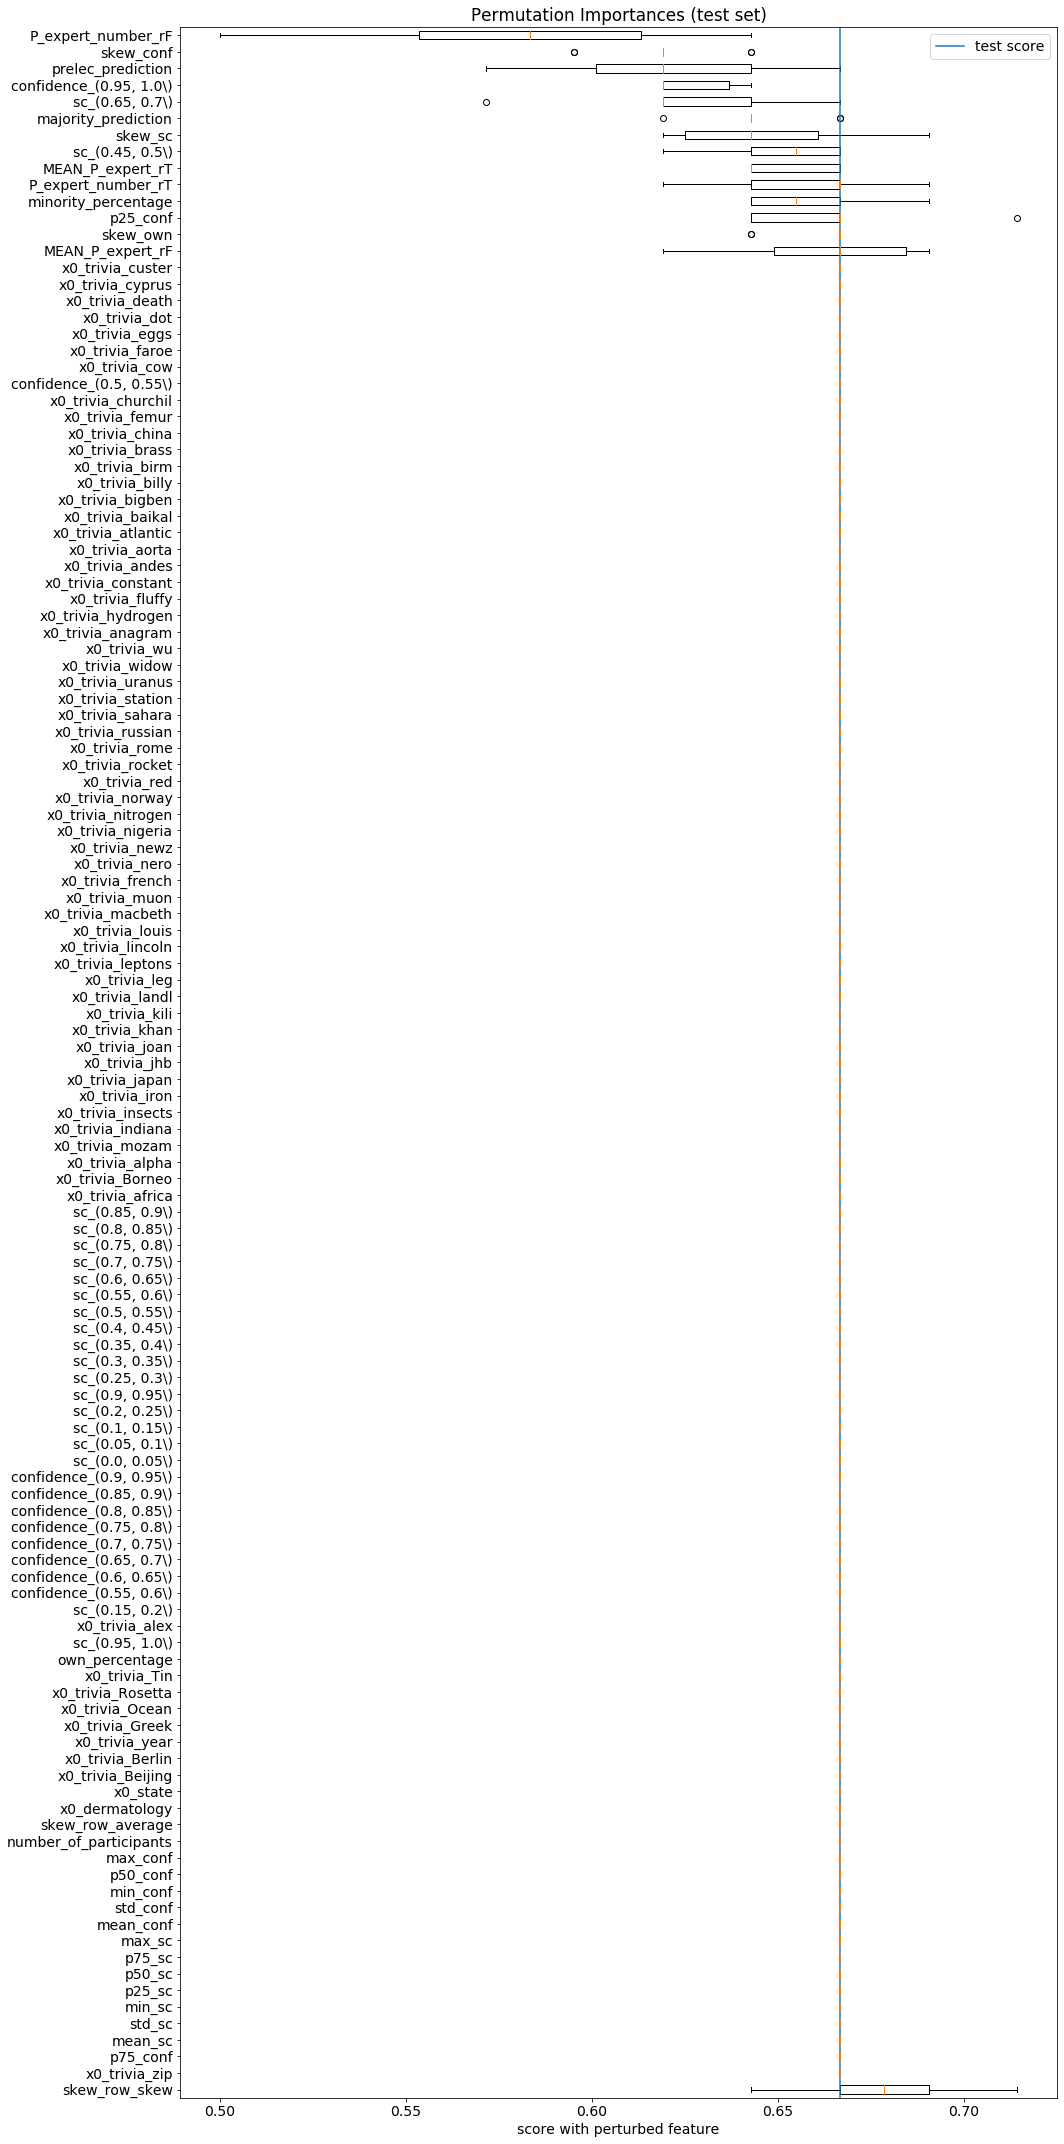

In [100]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(15,30))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix for the best Model

In [150]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [121]:
with_topic = pd.read_csv(f"Final_Datasets/not_preprocessed.csv")
# q = with_topic["Unnamed: 0"]
# with_topic = with_topic.set_index('Unnamed: 0')

with_topic.columns = ['question', 'actual', 'confidence_(0.5, 0.55]',
       'confidence_(0.55, 0.6]', 'confidence_(0.6, 0.65]',
       'confidence_(0.65, 0.7]', 'confidence_(0.7, 0.75]',
       'confidence_(0.75, 0.8]', 'confidence_(0.8, 0.85]',
       'confidence_(0.85, 0.9]', 'confidence_(0.9, 0.95]',
       'confidence_(0.95, 1.0]', 'sc_(0.0, 0.05]', 'sc_(0.05, 0.1]',
       'sc_(0.1, 0.15]', 'sc_(0.15, 0.2]', 'sc_(0.2, 0.25]', 'sc_(0.25, 0.3]',
       'sc_(0.3, 0.35]', 'sc_(0.35, 0.4]', 'sc_(0.4, 0.45]', 'sc_(0.45, 0.5]',
       'sc_(0.5, 0.55]', 'sc_(0.55, 0.6]', 'sc_(0.6, 0.65]', 'sc_(0.65, 0.7]',
       'sc_(0.7, 0.75]', 'sc_(0.75, 0.8]', 'sc_(0.8, 0.85]', 'sc_(0.85, 0.9]',
       'sc_(0.9, 0.95]', 'sc_(0.95, 1.0]', 'number_of_participants', 'own',
       'topic', 'mean_sc', 'std_sc', 'min_sc', 'p25_sc', 'p50_sc', 'p75_sc',
       'max_sc', 'mean_conf', 'std_conf', 'min_conf', 'p25_conf', 'p50_conf',
       'p75_conf', 'max_conf', 'skew_own', 'skew_sc', 'skew_conf',
       'skew_row_average', 'skew_row_skew', 'minority_percentage',
       'real_expert_number', 'P_expert_number_rT', 'P_expert_number_rF',
       'MEAN_P_expert_rT', 'MEAN_P_expert_rF', 'prelec_prediction',
       'majority_prediction']

RUNTHISDATAFRAME = with_topic
RUNTHISDATAFRAME = RUNTHISDATAFRAME.loc[:,~RUNTHISDATAFRAME.columns.duplicated()]

dta = RUNTHISDATAFRAME

X,y = prepare_data(dta)

X, enc_onehot, s_scaler = pre.preprocess_Xtrain(pre,X)

columns = []
for col in X.columns:
    if "[" in col:
        col = re.sub("[", "\(", col)
    elif "]" in col:
        col = re.sub("]", "\)", col)
    columns.append(col)

X.columns = columns

In [119]:
grid, X_test, y_test = ML_randomforest(X_other, X_test, y_other, y_test, 
                                                   kf=kf, random_state=872)

In [153]:
predictions = grid.best_estimator_.predict(X_test)

In [154]:
y_pred = predictions

In [155]:
y_true = y["actual"]

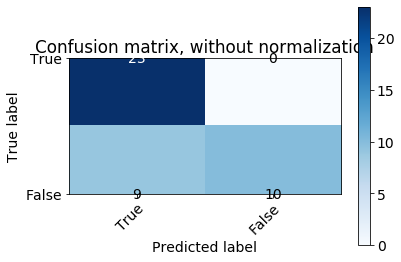

In [159]:
plot_confusion_matrix(y_test,y_pred,classes=['True','False'])
plt.show()